Author: **Ermishin Andrei**

Course: Introduction to Machine Learning

# Analysis of students performance in Stepik course

In [111]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [112]:
# To have bigger plot sizes and use sns output in pandas plot-commands.
sns.set(rc={'figure.figsize': (9, 6)})

## 1) Events data review

In [113]:
events = pd.read_csv('events_data_train.csv')
events.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [114]:
events['date'] = pd.to_datetime(events['timestamp'], unit='s')
events.head(3)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48


Using `dt` to access for datetimelike properties of the Series values.

In [115]:
events['day'] = events['date'].dt.date
events.head(3)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15


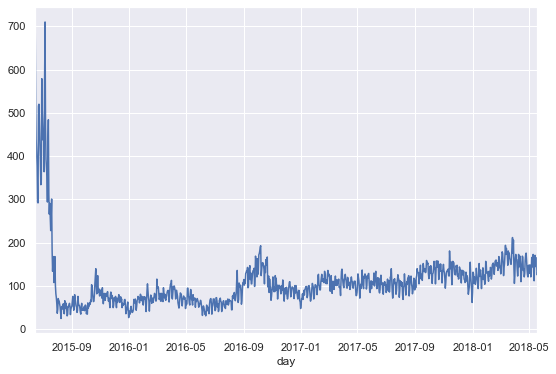

In [116]:
# How many unique users per day?
events.groupby('day')['user_id'].nunique().plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4BA6F6B38>]],
      dtype=object)

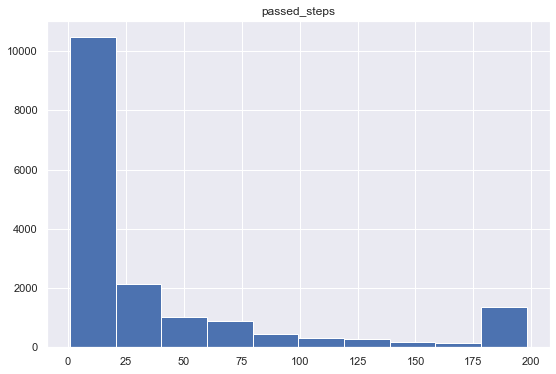

In [117]:
# Passed steps distribution:
events[events['action']=='passed'].groupby('user_id', as_index=False).agg(passed_steps=('action', 'count')).hist()

In [118]:
# Action distribution (fill_value=0  fills NaN with 0):
actions = events.pivot_table(index='user_id',
                   columns=['action'],
                   values=['step_id'],
                   aggfunc='count',
                   fill_value=0).reset_index(col_level=1)
actions.columns = actions.columns.droplevel(level=0)
actions.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


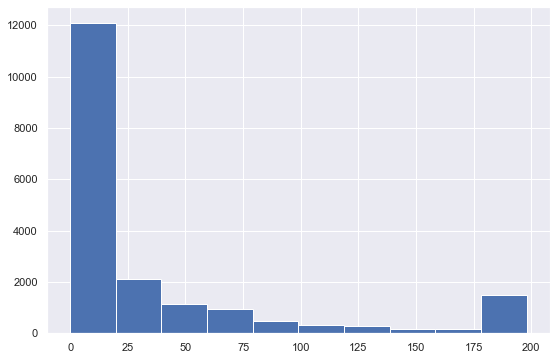

In [119]:
actions['discovered'].hist()

## 2) Submissions data review

In [120]:
submissions = pd.read_csv('submissions_data_train.csv')
submissions.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [121]:
submissions['date'] = pd.to_datetime(submissions['timestamp'], unit='s')
submissions['day'] = submissions['date'].dt.date
submissions.head(3)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11


In [122]:
users_scores = submissions.pivot_table(index='user_id',
                                       columns='submission_status',
                                       values='step_id',
                                       aggfunc='count',
                                       fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Now let's find `user_id` of lecturer or tester which completed correctly more steps than others.

In [123]:
# events.groupby('user_id')['day'].nunique().idxmax()
users_scores.nlargest(3, 'correct')

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177


In [124]:
users_scores.nlargest(3, 'correct')['user_id'].iloc[0]

1046

### Worst step in the course

After which **step/assignment** students had **no more submissions**?

In [125]:
submissions.head(2)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15


In [126]:
# Find last time of any submission for each user.
submissions_by_step = submissions.pivot_table(index=['user_id', 'step_id'],
                                              columns='submission_status',
                                              values='timestamp',
                                              aggfunc='max',
                                              fill_value=0).reset_index()
submissions_by_step.head(3)

submission_status,user_id,step_id,correct,wrong
0,2,32812,1514383485,0
1,2,32929,1514383420,0
2,3,31971,1441259266,0


In [127]:
# Find last time of action for each user.
users_last_submit = submissions.groupby('user_id').agg(last_timestamp=('timestamp', 'max')).reset_index()
users_last_submit.head(3)

,user_id,last_timestamp
0,2,1514383485
1,3,1444573728
2,5,1499859730


In [128]:
not_solved_steps = submissions_by_step[submissions_by_step['correct']==0].merge(users_last_submit, on='user_id')
not_solved_steps.head(3)

,user_id,step_id,correct,wrong,last_timestamp
0,8,31986,0,1480603825,1480604143
1,8,32089,0,1480603834,1480604143
2,14,33983,0,1436368601,1436368601


In [129]:
not_solved_steps[not_solved_steps['wrong']==not_solved_steps['last_timestamp']] \
    .groupby('step_id').agg(users=('user_id', 'count')).sort_values('users', ascending=False).head(3)

,users
step_id,
31978,151
32812,130
32031,95


## 3) Feature engineering for the model

How many **days** users were **absent**?

In [130]:
np.diff([1, 3, 14])

array([ 2, 11])

In [131]:
# Create a list of differences of two consecutive course visits:
gap_days = events[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
            .groupby('user_id')['timestamp'].apply(list) \
            .apply(np.diff).to_numpy()
gap_days[:5]

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]),
       array([33702812]), array([], dtype=int32)], dtype=object)

In [132]:
gap_days_seconds = np.concatenate(gap_days)    # array([4843602, 6899249,  182484, ..., 1567990])
day_seconds = 24 * 60 * 60
gap_days = pd.Series(gap_days_seconds / day_seconds)
gap_days.head(3)

0    56.060208
1    79.852419
2     2.112083
dtype: float64

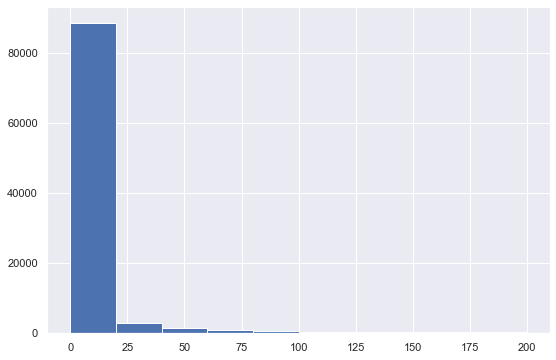

In [133]:
gap_days[gap_days < 200].hist()

In [134]:
print(gap_days.quantile(.95))    # only 5% of users have gaps > 60 days
gap_days.quantile(.90)

59.760440972222156


18.325995370370403

So, we will consider user as **dropped** from course if he was absent for **30 days**.

In [135]:
users_data = events.groupby('user_id').agg(last_visit=('timestamp', 'max')).reset_index()
users_data.head()

,user_id,last_visit
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [136]:
last_timestamp = events['timestamp'].max()
drop_out_30_days = 30 * day_seconds
users_data['is_user_gone'] = (last_timestamp - users_data['last_visit']) > drop_out_30_days
users_data.head(3)

,user_id,last_visit,is_user_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True


In [137]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data.head(3)

,user_id,last_visit,is_user_gone,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0


In [138]:
users_data = users_data.fillna(0)
users_data.head(3)

,user_id,last_visit,is_user_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0


In [139]:
users_data = users_data.merge(actions, on='user_id', how='outer')
users_data.head(3)

,user_id,last_visit,is_user_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192


In [140]:
users_nunique_days = events.groupby('user_id')['day'].nunique().to_frame(name='unique_days')

users_data = users_data.merge(users_nunique_days, on='user_id', how='outer')
users_data.head()

,user_id,last_visit,is_user_gone,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [141]:
# Check if we have no missing data:
events['user_id'].nunique() == users_data['user_id'].nunique()

True

In [142]:
# We'll consider a user as completed the course if he has > 170 steps passed:
users_data['passed_course'] = users_data['passed'] > 170
users_data.head()

,user_id,last_visit,is_user_gone,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [143]:
# The fraction of users that passed the course:
users_data['passed_course'].value_counts(normalize=True).to_frame()

,passed_course
False,0.925912
True,0.074088


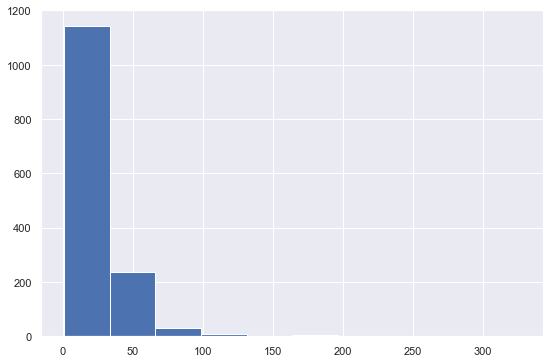

In [144]:
# How many unique days have users that passed the course?
users_data.loc[users_data['passed_course']==True, 'unique_days'].hist()

## 4) First 2 days in the course

So, let's filter data for first `2` days.

In [145]:
# User's first action in the course:
min_timestamp = events.groupby('user_id').agg(user_first_act=('timestamp', 'min')).reset_index()

users_data = users_data.merge(min_timestamp, on='user_id', how='outer')
users_data.head(3)

,user_id,last_visit,is_user_gone,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,user_first_act
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476


Now we take only data for every user for `threshold` days:

### Extract 2 days from the initial events dataset

In [146]:
threshold = 2 * day_seconds
users_data['first_plus_2days'] = users_data['user_first_act'] + threshold
users_data.head(3)

,user_id,last_visit,is_user_gone,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,user_first_act,first_plus_2days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464,1473000264
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364,1514556164
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476,1434531276


In [147]:
df = events.merge(users_data[['user_id', 'first_plus_2days']], on='user_id', how='outer')
print(df.shape)
events_first_2days = df[ df['timestamp'] <= df['first_plus_2days'] ]
print(events_first_2days.shape)
events_first_2days.head(3)

(3480703, 7)
(906203, 7)


,step_id,timestamp,action,user_id,date,day,first_plus_2days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434513648


In [148]:
events_first_2days.groupby('user_id')['day'].nunique().max() <= 3

True

### Extract 2 days from the initial submissions dataset

In [149]:
# how='left': use only keys from left frame (submissions), so we don't need users from events with no submissions.
df = submissions.merge(users_data[['user_id', 'first_plus_2days']], on='user_id', how='left')
print(df.shape)
submissions_first_2days = df[ df['timestamp'] <= df['first_plus_2days'] ]
print(submissions_first_2days.shape)
submissions_first_2days.head(3)

(509104, 7)
(115466, 7)


,step_id,timestamp,submission_status,user_id,date,day,first_plus_2days
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434518777
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434518777
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434518777


In [150]:
submissions_first_2days.groupby('user_id')['day'].nunique().max() <= 3

True

## 5) Prepare features for the model

In [151]:
X = submissions_first_2days.groupby('user_id')['day'].nunique().to_frame(name='unique_days').reset_index()
print(X.shape)
X.head(3)

(8815, 2)


,user_id,unique_days
0,2,1
1,3,1
2,8,1


In [152]:
X = X.merge(submissions_first_2days.groupby('user_id')['step_id'] \
                                .nunique().to_frame(name='steps_tried').reset_index(),
            on='user_id', how='outer')
X.head(3)

,user_id,unique_days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11


In [153]:
X = X.merge(submissions_first_2days.pivot_table(index='user_id',
                                                columns='submission_status',
                                                values='step_id',
                                                aggfunc='count',
                                                fill_value=0).reset_index(),
            on='user_id', how='outer')
X.head(3)

,user_id,unique_days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21


We can help our model by adding a feature of correct/wrong ratio:

In [154]:
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])
X.head(3)

,user_id,unique_days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.0
1,3,1,4,4,4,0.5
2,8,1,11,9,21,0.3


In [155]:
steps_viewed = events_first_2days.pivot_table(index='user_id',
                                              columns=['action'],
                                              values=['step_id'],
                                              aggfunc='count',
                                              fill_value=0).reset_index(col_level=1)
steps_viewed.columns = steps_viewed.columns.droplevel(level=0)

X = X.merge(steps_viewed[['user_id', 'viewed']], on='user_id', how='outer')
X.fillna(0, inplace=True)    # fill rows where users only viewed steps
print(X.shape)
X.head(3)

(19234, 7)


,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.0,9
1,3,1.0,4.0,4.0,4.0,0.5,20
2,8,1.0,11.0,9.0,21.0,0.3,154


In [156]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_user_gone']], on='user_id', how='outer')
print(X.shape)
X.head(3)

(19234, 9)


,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_user_gone
0,2,1.0,2.0,2.0,0.0,1.0,9,False,True
1,3,1.0,4.0,4.0,4.0,0.5,20,False,True
2,8,1.0,11.0,9.0,21.0,0.3,154,False,True


In [157]:
# We consider only students that are gone already or passed the course.
X_170_steps = X.loc[ (X['passed_course']==True) | (X['is_user_gone']==True) ]
X_170_steps.groupby(['passed_course', 'is_user_gone'])['user_id'].count()

passed_course  is_user_gone
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [158]:
X_170_steps.set_index('user_id', inplace=True)

y = X_170_steps['passed_course'].astype(int)
X_170_steps.drop(['passed_course', 'is_user_gone'], axis='columns', inplace=True)
print(X_170_steps.shape)
X_170_steps.head(3)

(17985, 6)


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,unique_days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.0,9
3,1.0,4.0,4.0,4.0,0.5,20
8,1.0,11.0,9.0,21.0,0.3,154


## 6) Train the model

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11)

In [ ]:
%%time
params = {'n_estimators': range(10, 60, 20),
          #some params}
search = GridSearchCV(rf, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
search.fit(X_170_steps, y)
search.best_score_, search.best_params_

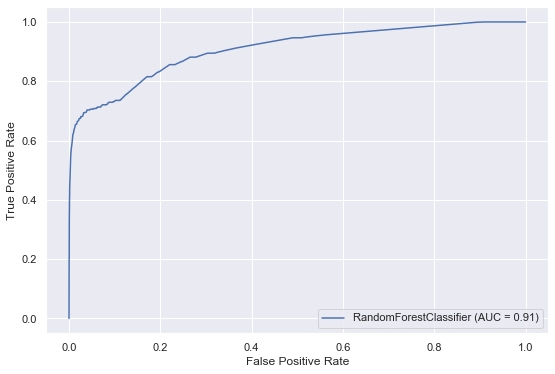

In [161]:
from sklearn.metrics import plot_roc_curve

# ROC_AUC on train data:
plot_roc_curve(search.best_estimator_, X_170_steps, y)

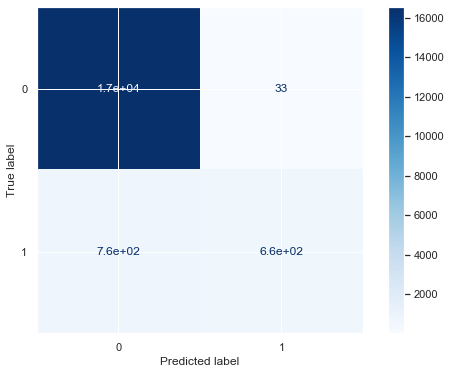

In [162]:
from sklearn.metrics import plot_confusion_matrix

# ROC_AUC on test data:
plot_confusion_matrix(search.best_estimator_, X_170_steps, y, cmap='Blues')

## 7) Practise exercises as measure of finishing the course

In [163]:
# Data for first 2 days of each user:
X.head(3)

,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_user_gone
0,2,1.0,2.0,2.0,0.0,1.0,9,False,True
1,3,1.0,4.0,4.0,4.0,0.5,20,False,True
2,8,1.0,11.0,9.0,21.0,0.3,154,False,True


In [164]:
# Some helping feature:
X['num_wrong_vs_steps'] = X['wrong'] / X['steps_tried']
X.fillna(0, inplace=True)
print(X.shape)
X.head()

(19234, 10)


,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_user_gone,num_wrong_vs_steps
0,2,1.0,2.0,2.0,0.0,1.000000,9,False,True,0.000000
1,3,1.0,4.0,4.0,4.0,0.500000,20,False,True,1.000000
2,8,1.0,11.0,9.0,21.0,0.300000,154,False,True,1.909091
3,14,1.0,1.0,0.0,1.0,0.000000,9,False,True,1.000000
4,16,2.0,18.0,18.0,23.0,0.439024,117,True,True,1.277778


Let's check if any user has **finished** the course with **more than 40** completed practise exercises.

In [165]:
# Find number of unique completed exercises for all time:
X = X.merge(submissions[submissions['submission_status']=='correct'] \
                .groupby('user_id')['step_id'].nunique().to_frame(name='num_solved').reset_index(),
            on='user_id', how='left')

X.fillna(0, inplace=True)
print(X.shape)
X.head(3)

(19234, 11)


,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_user_gone,num_wrong_vs_steps,num_solved
0,2,1.0,2.0,2.0,0.0,1.0,9,False,True,0.000000,2.0
1,3,1.0,4.0,4.0,4.0,0.5,20,False,True,1.000000,29.0
2,8,1.0,11.0,9.0,21.0,0.3,154,False,True,1.909091,9.0


In [166]:
X.loc[X['num_solved']>= 40, 'passed_course'].value_counts(normalize=True)

True     0.725191
False    0.274809
Name: passed_course, dtype: float64

So, **73% of all users finished** the course if they have **>= 40** completed practise exercises.

In [169]:
X['solved40'] = X['num_solved']>= 40
print(X.shape)
X.head(3)

(19234, 12)


,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_user_gone,num_wrong_vs_steps,num_solved,solved40
0,2,1.0,2.0,2.0,0.0,1.0,9,False,True,0.000000,2.0,False
1,3,1.0,4.0,4.0,4.0,0.5,20,False,True,1.000000,29.0,False
2,8,1.0,11.0,9.0,21.0,0.3,154,False,True,1.909091,9.0,False


In [171]:
X_40 = X.set_index('user_id')

y = X_40['solved40'].astype(int)

X_40.drop(['passed_course', 'is_user_gone',
           'num_solved', 'solved40'], axis='columns', inplace=True)

print(X_40.shape)
X_40.head()

(19234, 7)


,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,num_wrong_vs_steps
user_id,,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9,0.000000
3,1.0,4.0,4.0,4.0,0.500000,20,1.000000
8,1.0,11.0,9.0,21.0,0.300000,154,1.909091
14,1.0,1.0,0.0,1.0,0.000000,9,1.000000
16,2.0,18.0,18.0,23.0,0.439024,117,1.277778


## 8) Train the model for 40 solved exercises

In [ ]:
%%time
params = {#some params}
search = GridSearchCV(rf, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
search.fit(X_40, y)
search.best_score_, search.best_params_

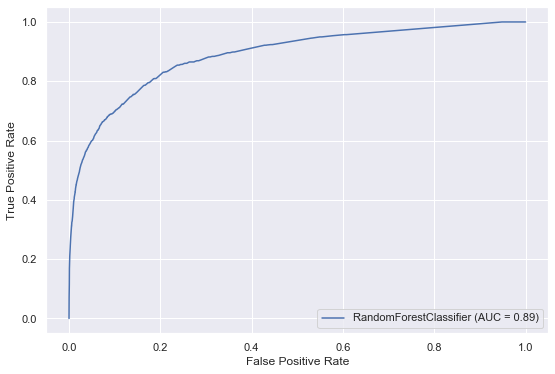

In [209]:
# ROC_AUC on train data:
plot_roc_curve(search.best_estimator_, X_40, y)

In [174]:
# best_rf = search.best_estimator_

In [176]:
import pickle

# with open('stepic_contest_rf_model.pickle', 'wb') as out:
#     pickle.dump(best_rf, out)

with open('stepic_contest_rf_model.pickle', 'rb') as inp:
    best_rf = pickle.load(inp)

## 9) Predict the users' drop-off

In [178]:
submission_example = pd.read_csv('submission_example.csv')
print(submission_example.shape)
submission_example.head(3)

(6184, 2)


,user_id,is_gone
0,12,0.26
1,13,0.79
2,15,0.12


### Prepare test data for the model

In [188]:
print('We need columns:', list(X_40.columns))

We need columns: ['unique_days', 'steps_tried', 'correct', 'wrong', 'correct_ratio', 'viewed', 'num_wrong_vs_steps']


In [182]:
# Test data consists of data for first 2 days for each user.
events_test = pd.read_csv('events_data_test.csv')
print(events_test.shape)
events_test.head(3)

(274768, 4)


,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417


In [181]:
submissions_test = pd.read_csv('submissions_data_test.csv')
print(submissions_test.shape)
submissions_test.head(3)

(42261, 4)


,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370


In [183]:
submissions_test['date'] = pd.to_datetime(submissions_test['timestamp'], unit='s')
submissions_test['day'] = submissions_test['date'].dt.date
submissions_test.head(3)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20


In [184]:
X_test = submissions_test.groupby('user_id')['day'].nunique().to_frame(name='unique_days').reset_index()
print(X_test.shape)
X_test.head(3)

(2803, 2)


,user_id,unique_days
0,12,1
1,13,2
2,15,3


In [189]:
X_test = X_test.merge(submissions_test.groupby('user_id')['step_id'] \
                        .nunique().to_frame(name='steps_tried').reset_index(),
                      on='user_id', how='outer')
print(X_test.shape)
X_test.head(3)

(2803, 3)


,user_id,unique_days,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11


In [191]:
X_test = X_test.merge(submissions_test \
                          .pivot_table(index='user_id',
                                       columns='submission_status',
                                       values='step_id',
                                       aggfunc='count',
                                       fill_value=0).reset_index(),
                      on='user_id', how='outer')
X_test.head(3)

,user_id,unique_days,steps_tried,correct,wrong
0,12,1,1,1,0
1,13,2,29,29,36
2,15,3,11,10,30


In [197]:
X_test['correct_ratio'] = X_test['correct'] / (X_test['correct'] + X_test['wrong'])

steps_viewed = events_test.pivot_table(index='user_id',
                                              columns=['action'],
                                              values=['step_id'],
                                              aggfunc='count',
                                              fill_value=0).reset_index(col_level=1)
steps_viewed.columns = steps_viewed.columns.droplevel(level=0)

X_test = X_test.merge(steps_viewed[['user_id', 'viewed']], on='user_id', how='outer')
X_test.fillna(0, inplace=True)    # fill rows where users only viewed steps
print(X_test.shape)
X_test.head(3)

(6184, 7)


,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed
0,12,1.0,1.0,1.0,0.0,1.000000,14
1,13,2.0,29.0,29.0,36.0,0.446154,105
2,15,3.0,11.0,10.0,30.0,0.250000,1


In [202]:
X_test['num_wrong_vs_steps'] = X_test['wrong'] / X_test['steps_tried']
X_test.fillna(0, inplace=True)
X_test.set_index('user_id', inplace=True)
print(X_test.shape)
X_test.head(3)

(6184, 7)


,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,num_wrong_vs_steps
user_id,,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14,0.000000
13,2.0,29.0,29.0,36.0,0.446154,105,1.241379
15,3.0,11.0,10.0,30.0,0.250000,1,2.727273


### Make predictions

In [210]:
y_pred = best_rf.predict_proba(X_test)[:, 1]
y_pred[:3]

array([0.04393166, 0.52857143, 0.26428571])

In [211]:
output = pd.DataFrame({'user_id': X_test.index,
                       'is_gone': y_pred})
output.to_csv('submission.csv', index=False)